<img src="https://cienciasgeodesicas.ufpr.br/wp-content/uploads/2021/03/cropped-folder-site3.png" alt="Drawing"/>

**Federal University of Parana, Curitiba, Brazil**

Geodetic Science Graduate Programme

---

Authors:
 - Darlan Miranda Nunes | [ORCID- 0000-0003-3557-5341](https://orcid.org/0000-0001-5566-7919)
 - Silvana Philippi Camboim | [ORCID- 0000-0003-3557-5341](https://orcid.org/0000-0003-3557-5341)
---

## Are National Spatial Data Infrastructures Adequate for Achieving the 2030 Agenda? A Case Study of Brazil's NSDI from the Perspective of UN-GGIM Fundamental Themes


### **Aims**

- This Jupyter notebook explore the current scenario of the Brazilian NSDI (INDE, in portuguese) in relation to the 14 Global Fundamental Geospatial Data Themes adopted by UN-GGIM.

- Through this open-source approach, we can gather all data from the INDE’s GeoPortal and categorize them into the fundamental themes and provide some important analysis.

### Install and load the necessary libraries

In [135]:
# Main libraries to install (in case of using Google Colab)
%pip install owslib unidecode ipywidgets plotly kaleido -q

Note: you may need to restart the kernel to use updated packages.


In [88]:
# Import the libraries and modules to the project
import warnings
warnings.filterwarnings('ignore')

import os
import re
import csv
import numpy as np
import pandas as pd
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
import requests
from owslib.wms import WebMapService
from owslib.util import ServiceException
from requests.exceptions import RequestException, SSLError, ConnectionError, Timeout
from urllib3.exceptions import MaxRetryError, NewConnectionError
import pandas as pd
from unidecode import unidecode
import time
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import random
import plotly.express as px
import plotly.io as pio
import kaleido
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output


### Connect to Google Drive (in case of using Google Colab)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the current directory
%cd '/content/drive'

In [ ]:
!ls

In [ ]:
# Define the directory path
path = os.getcwd()
path


### Use a JSON request to retrieve the list of geoservices catalog available on the INDE's Geoportal






In [10]:
url = "https://inde.gov.br/api/catalogo/get"

response = requests.get(url, verify=False)  # Ignore SSL certificate verification
page_content = response.text

df_list = pd.read_json(page_content)
df_list.head()

,descricao,url,nivel_no,wmsAvailable,wfsAvailable,wcsAvailable,wmsGetCapabilities,wfsGetCapabilities,wcsGetCapabilities
0,ANA - Agência Nacional de Águas e Saneamento B...,https://www.snirh.gov.br/arcgis/services/INDE/...,Nacional,True,False,False,https://www.snirh.gov.br/arcgis/services/INDE/...,None,None
1,ANATEL - Agência Nacional de Telecomunicações,http://sistemas.anatel.gov.br:80/geoserver/ANA...,Nacional,True,True,True,http://sistemas.anatel.gov.br:80/geoserver/ANA...,http://sistemas.anatel.gov.br:80/geoserver/ANA...,http://sistemas.anatel.gov.br:80/geoserver/ANA...
2,ANM - Agência Nacional de Mineração,https://geoservicos.inde.gov.br/geoserver/ANM/ows,Nacional,True,False,False,https://geoservicos.inde.gov.br/geoserver/ANM/...,None,None
3,"ANP - Agência Nacional do Petróleo, Gás Natura...",https://gishub.anp.gov.br/geoserver/ows,Governo local,True,True,True,https://gishub.anp.gov.br/geoserver/ows?servic...,https://gishub.anp.gov.br/geoserver/ows?servic...,https://gishub.anp.gov.br/geoserver/ows?servic...
4,ANTT - Agência Nacional de Transporte Terrestres,https://geoservicos.inde.gov.br/geoserver/ANTT...,Nacional,True,True,True,https://geoservicos.inde.gov.br/geoserver/ANTT...,https://geoservicos.inde.gov.br/geoserver/ANTT...,https://geoservicos.inde.gov.br/geoserver/ANTT...


In [11]:
# How many geoservices are currently available in INDE's Geoportal?
len(df_list)

82

### Level of institutions Nodes participating in the INDE

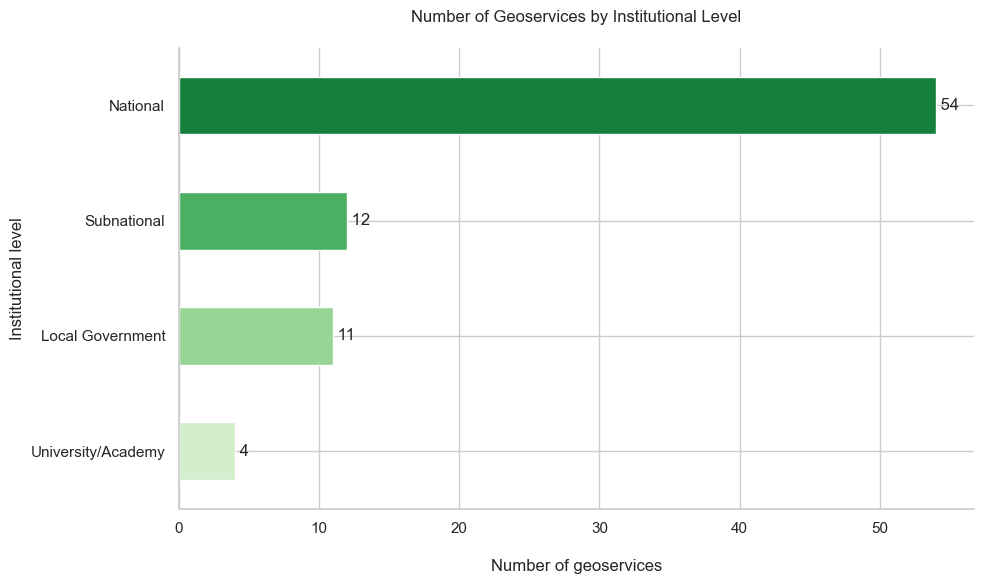

In [12]:
# Level of institutions Nodes participating in the INDE

df_list2 = df_list.copy()

# Translate categories
translation_dict = {
    'Nacional': 'National',
    'Subnacional': 'Subnational',
    'Governo local': 'Local Government',
    'Universidade/Academia': 'University/Academy'
}

df_list2['nivel_no'] = df_list2['nivel_no'].map(translation_dict)

# Group by 'nivel_no', count and sort in ascending order
level_counts = df_list2.groupby('nivel_no').size().sort_values()

# Cor palette by level counts
green_palette = sns.color_palette("Greens", len(level_counts))

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
bars = level_counts.plot(kind='barh', color=green_palette, ax=ax)
ax.set_title('Number of Geoservices by Institutional Level\n')
ax.set_xlabel('\nNumber of geoservices')
ax.set_ylabel('Institutional level')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add text labels to the end of each bar
for bar in bars.patches:
    ax.text(bar.get_width(),  # Set the text at the end of each bar
            bar.get_y() + bar.get_height() / 2,  # Set the text in the middle of the bar vertically
            f' {bar.get_width()}',  # Text to display (count of geoservices)
            va='center')  # Vertically align text in the center

# Adjust layout
plt.tight_layout()

# Define path and filename
path = '../results'  # Path to the results directory
filename = 'fig1_geoservices_by_institutional_level.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using os.path.join
full_path = os.path.join(path, filename)
plt.savefig(full_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

### Availability of geospatial services according to OGC standards

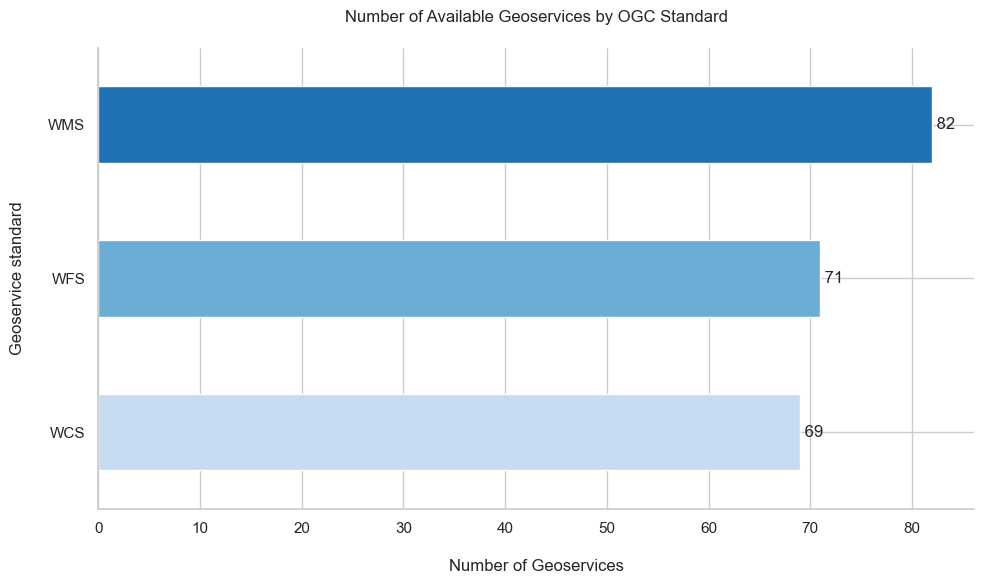

In [18]:
# Calculate the total available services for each type
service_counts = df_list[['wmsAvailable', 'wfsAvailable', 'wcsAvailable']].sum()

# Rename indices to more appropriate names
service_counts.index = ['WMS', 'WFS', 'WCS']

# Sort the values
service_counts = service_counts.sort_values()

# Color palette (using shades of blue to differentiate from previously used greens)
blue_palette = sns.color_palette("Blues", len(service_counts))

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
bars = service_counts.plot(kind='barh', color=blue_palette, ax=ax)
ax.set_title('Number of Available Geoservices by OGC Standard\n')
ax.set_xlabel('\nNumber of Geoservices')
ax.set_ylabel('Geoservice standard\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add text labels to the end of each bar
for bar in bars.patches:
    ax.text(bar.get_width(),  # Set the text at the end of each bar
            bar.get_y() + bar.get_height() / 2,  # Set the text in the middle of the bar vertically
            f' {bar.get_width()}',  # Text to display (count of geoservices)
            va='center')  # Vertically align text in the center

# Adjust layout
plt.tight_layout()

# Define path and filename
path = '../results'  # Path to the results directory
filename = 'fig2_available_geoservices_OGC-standard.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using os.path.join
full_path = os.path.join(path, filename)
plt.savefig(full_path, format='png', dpi=300, bbox_inches='tight')
plt.show()


### WebScraping of the geospatial data layers information available in the INDE's GeoPortal through WMS standard


In [ ]:
# Ignore SSL certificate verification
requests.packages.urllib3.disable_warnings()

# Select the columns of interest from the DataFrame
cols = ['nome_instituicao', 'nivel_no', 'wmsGetCapabilities', 'layer_name', 'titulo', 'abstract', 'estilo_padrao', 'SRC']
data = []
error_urls = []

start_time = time.time()

def fetch_url(url):
    try:
        response = requests.get(url, timeout=180, verify=False)
        response.raise_for_status()
        return WebMapService(url, timeout=180)
    except (SSLError, ConnectionError) as e:
        print(f"Network or SSL error on {url}: {e}")
    except RequestException as e:
        print(f"HTTP error on {url}: {e}")
    except Exception as e:
        print(f"Unexpected error on {url}: {e}")
    return None

for url in tqdm(df_list["wmsGetCapabilities"], desc="Processing URLs"):
    wms = fetch_url(url)
    if not wms:
        error_urls.append(url)
        continue

    try:
        for layer_name, layer_info in wms.contents.items():
            default_style = next(iter(layer_info.styles.values()))['title'] if layer_info.styles else "No default style"
            crs_options = layer_info.crsOptions
            data.append({
                'nome_instituicao': df_list.loc[df_list['wmsGetCapabilities'] == url, 'descricao'].iloc[0],
                'nivel_no': df_list.loc[df_list['wmsGetCapabilities'] == url, 'nivel_no'].iloc[0],
                'wmsGetCapabilities': df_list.loc[df_list['wmsGetCapabilities'] == url, 'wmsGetCapabilities'].iloc[0],
                'layer_name': layer_name,
                'titulo': layer_info.title,
                'abstract': layer_info.abstract,
                'estilo_padrao': default_style,
                'SRC': crs_options
            })
    except Exception as e:
        print(f"Error processing layers from {url}: {e}")
        error_urls.append(url)

df = pd.DataFrame(data, columns=cols)
elapsed_time = time.time() - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds")
print("DataFrame:")
print(df.head())
if error_urls:
    print("Failed to process the following URLs:")
    for err_url in error_urls:
        print(err_url)

In [43]:
df.head()

,nome_instituicao,nivel_no,wmsGetCapabilities,layer_name,titulo,abstract,estilo_padrao,SRC
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,https://www.snirh.gov.br/arcgis/services/INDE/...,0,Usos Consuntivos da Água - Demanda hídrica por...,None,Usos Consuntivos da Água - Demanda hídrica por...,"[EPSG:4326, EPSG:4674]"
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,https://www.snirh.gov.br/arcgis/services/INDE/...,1,Usos Consuntivos da Água - Demanda hídrica por...,None,Usos Consuntivos da Água - Demanda hídrica por...,"[EPSG:4326, EPSG:4674]"
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,https://www.snirh.gov.br/arcgis/services/INDE/...,2,Usos Consuntivos da Água - Demanda hídrica por...,None,Usos Consuntivos da Água - Demanda hídrica por...,"[EPSG:4326, EPSG:4674]"
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,https://www.snirh.gov.br/arcgis/services/INDE/...,3,Usos Consuntivos da Água - Demanda hídrica por...,None,Usos Consuntivos da Água - Demanda hídrica por...,"[EPSG:4326, EPSG:4674]"
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,https://www.snirh.gov.br/arcgis/services/INDE/...,4,Usos Consuntivos da Água - Demanda hídrica por...,None,Usos Consuntivos da Água - Demanda hídrica por...,"[EPSG:4326, EPSG:4674]"


In [44]:
# Numbers of rows and columns in the dataframe (i.e. number of geospatial data layer services)
df.shape

(25688, 8)

In [45]:
# Number of URLs with errors
number_of_errors = len(error_urls)
print("Number of URLs with errors: ", number_of_errors)

Number of URLs with errors:  27


In [46]:
# Lista de urls onde retornou erro:
error_urls

['http://sistemas.anatel.gov.br:80/geoserver/ANATEL/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://cmr.funai.gov.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpafac.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnptia.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpamt.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpatu.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cpact.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnpgl.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnpma.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&version=1.3.0',
 'https://geoinfo.cnpms.embrapa.br/geoserver/ows?service=wms&request=GetCapabilities&versi

In [ ]:
## Code for retrying requests with timeout and Exponential Backoff
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Disable SSL warnings due to verify=False
requests.packages.urllib3.disable_warnings()

def fetch_url_with_retry(url, retries=5, backoff_factor=0.3):
    "Function for retrying requests with timeout and exponential backoff"
    for i in range(retries):
        try:
            response = requests.get(url, timeout=(10, 30), verify=False)
            response.raise_for_status()
            return WebMapService(url, timeout=30)
        except (Timeout, ConnectionError) as e:
            sleep_time = backoff_factor * (2 ** i) + random.uniform(0, 0.1)
            logging.warning(f"Timeout or connection error for {url}. Retrying in {sleep_time:.2f} seconds (Attempt {i+1}/{retries})")
            time.sleep(sleep_time)
        except (SSLError, RequestException) as e:
            logging.error(f"SSL or Request error for {url}: {e}")
            break
        except Exception as e:
            logging.error(f"Unexpected error on {url}: {e}")
            break
    return None

successful_retries = []
new_error_urls = []
new_rows = []

for url in tqdm(error_urls, desc="Retrying failed URLs"):
    wms = fetch_url_with_retry(url)
    if wms:
        try:
            for layer_name, layer_info in wms.contents.items():
                default_style = next(iter(layer_info.styles.values()))['title'] if layer_info.styles else "No default style"
                crs_options = layer_info.crsOptions
                new_rows.append({
                    'nome_instituicao': df_list.loc[df_list['wmsGetCapabilities'] == url, 'descricao'].iloc[0],
                    'nivel_no': df_list.loc[df_list['wmsGetCapabilities'] == url, 'nivel_no'].iloc[0],
                    'wmsGetCapabilities': df_list.loc[df_list['wmsGetCapabilities'] == url, 'wmsGetCapabilities'].iloc[0],
                    'layer_name': layer_name,
                    'titulo': layer_info.title,
                    'abstract': layer_info.abstract,
                    'estilo_padrao': default_style,
                    'SRC': crs_options
                })
            successful_retries.append(url)
        except Exception as e:
            logging.error(f"Failed to process layers from {url} after retry: {e}")
            new_error_urls.append(url)
    else:
        new_error_urls.append(url)

# Display the retrying results
logging.info("Successfully retried the following URLs:")
for url in successful_retries:
    logging.info(url)

logging.info("Still failed to process the following URLs after retries:")
for url in new_error_urls:
    logging.info(url)

In [ ]:
df.shape

##### Local attempts requests (not applied)

In [ ]:
## Local attempts

# Setup
local_files_path = '../data/local_html_wms'
df_backup = df.copy()  # Backup of the original DataFrame
cols = ['nome_instituicao', 'nivel_no', 'wmsGetCapabilities', 'layer_name', 'titulo', 'abstract', 'estilo_padrao', 'SRC']
data = []
start_time = time.time()

# Helper function to parse WMS from XML
def parse_wms_from_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            xml_content = file.read()
            wms = WebMapService(None, xml=xml_content)
            return wms
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    return None

# Load all files in the directory
xml_files = [file for file in os.listdir(local_files_path) if file.endswith('.xml')]

# Processing each XML file
for file_name in tqdm(xml_files, desc="Processing XML Files"):
    file_path = os.path.join(local_files_path, file_name)
    wms = parse_wms_from_file(file_path)
    
    if not wms:
        continue
    
    df_entry = get_df_list_data(file_name.replace('.xml', ''))  # Assuming file_name is usable to match df_list entries

    if df_entry is None:
        print(f"No df_list entry found for {file_name}")
        continue

    try:
        for layer_name, layer_info in wms.contents.items():
            default_style = next(iter(layer_info.styles.values()))['title'] if layer_info.styles else "No default style"
            crs_options = layer_info.crsOptions
            data.append({
                'nome_instituicao': df_entry['descricao'],
                'nivel_no': df_entry['nivel_no'],
                'wmsGetCapabilities': df_entry['wmsGetCapabilities'],
                'layer_name': layer_name,
                'titulo': layer_info.title,
                'abstract': layer_info.abstract,
                'estilo_padrao': default_style,
                'SRC': crs_options
            })
    except Exception as e:
        print(f"Error processing layers from {file_name}: {e}")

# Create a new DataFrame from processed data
new_df = pd.DataFrame(data, columns=cols)
df2 = pd.concat([df, new_df], ignore_index=True)

# Summary of processing
elapsed_time = time.time() - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds")
print("DataFrame:")
print(df2.info())
print(df2.head())

#### Save the results in a CSV file

In [91]:
# Save the results in CSV file
def save_df_to_csv(df, filename):
    """
    Save the provided DataFrame to a CSV file.

    Parameters:
        df (pd.DataFrame): DataFrame to be saved.
        filename (str): File name or path where the CSV will be saved.
    """
    if df is not None and not df.empty:
        try:
            df.to_csv(filename, index=False, encoding='utf-8')
            print(f"DataFrame saved successfully to '{filename}'")

        except Exception as e:
            print(f"Failed to save DataFrame to '{filename}': {e}")

    else:
        print("DataFrame is empty or not defined. No file was saved.")

In [49]:
# Define path and filename
path = '../data'  # Path to the results directory
filename = '20240506_classified_geoservicos_inde_v2.csv'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save to results
full_path = os.path.join(path, filename)
save_df_to_csv(df, full_path)

DataFrame saved successfully to '../data/20240506_classified_geoservicos_inde.csv'


#### Import the CSV file (if necessary)

In [50]:
# If necessary, re-import the CSV with all the records
# Define path and filename
path = '../data'  # Path to the results directory
filename = '20240506_classified_geoservicos_inde_v2.csv'  # filename to be imported

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# full path to file
full_path = os.path.join(path, filename)

df_inde_scraped = pd.read_csv(full_path)
df_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,sigla,tema_fundamental,escala,classification
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,NaN,classified
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,NaN,classified
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,NaN,classified
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,NaN,classified
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,NaN,classified


In [51]:
df_inde_scraped = df_inde_scraped.drop(['tema_fundamental', 'escala'], axis=1)

In [52]:
df_inde_scraped.shape

(26717, 9)

In [6]:
df_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']"
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']"
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']"
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']"
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']"


In [15]:
# This code verifies if there are any missing institutions in df_inde_scraped

# Function to extract the acronym of the institution
def extract_initials(name):
    return name.split(' - ')[0]

# Apply the function to extract the acronym of the institution in both dataframes
df_list['sigla'] = df_list['descricao'].apply(extract_initials)
df_inde_scraped['sigla'] = df_inde_scraped['nome_instituicao'].apply(extract_initials)

# Unique acronyms in df_list
unique_siglas_list = set(df_list['sigla'].unique())

# Unique acronyms in df_inde_scraped
unique_siglas_df = set(df_inde_scraped['sigla'].unique())

# Find the acronyms that are in df_list but not in df_inde_scraped
missing_institutions = unique_siglas_list.difference(unique_siglas_df)

# Calculate the percentage of missing institutions
percent_missing = len(missing_institutions) / len(unique_siglas_list) * 100

# Display the results
print("Institutions not present in df_inde_scraped:")
for inst in missing_institutions:
    print(inst)
print(f"\nPercentage of missing institutionss: {percent_missing:.2f}%")

Institutions not present in df_inde_scraped:
Prefeitura de Belo Horizonte (MG)
SEMA (CE)
UNILA
PRODEMG (MG)
EMBRAPA Agricultura Digital
MB/DHN
Prefeitura Municipal de Santo André
SFB
SEPLAN (TO)
SEPLAG (AL)
SEFIN
CMR/Funai
 FAB/COMAE

Percentage of missing institutionss: 16.05%


### Frequency histogram of institutions participating in the INDE

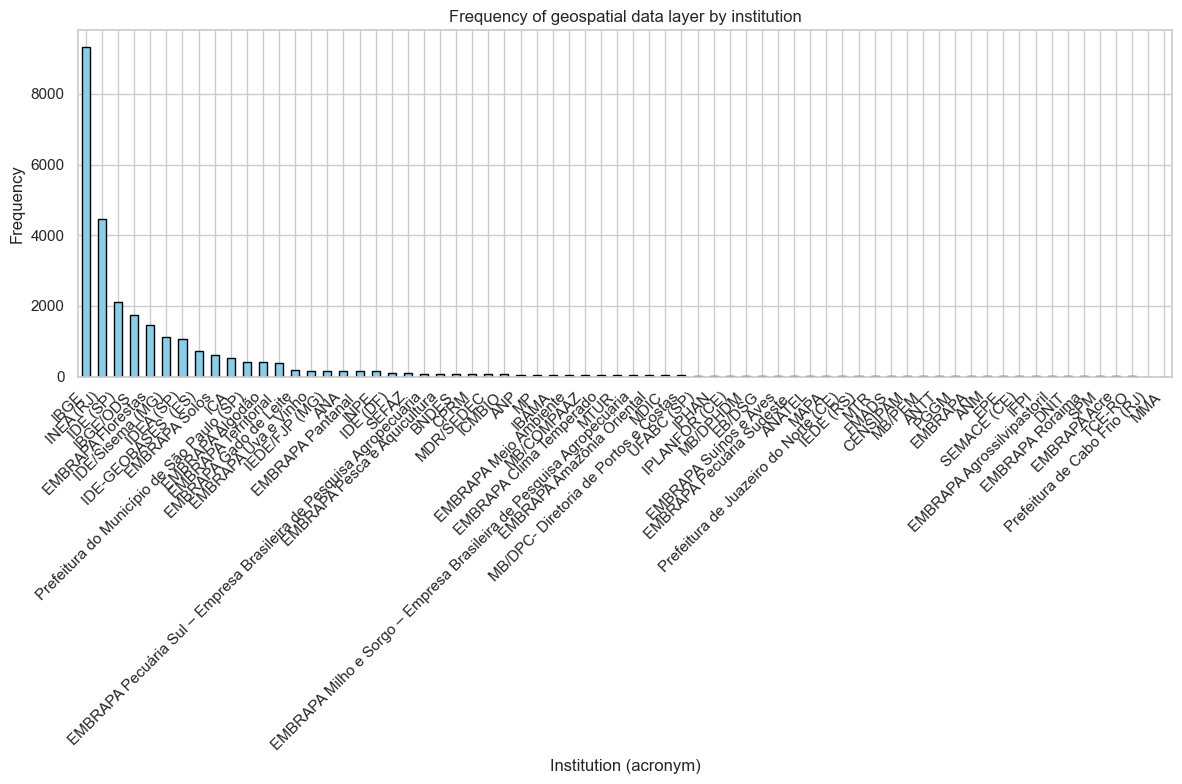

In [53]:
# Count the number of occurrences of each institution acronym
institution_count = df_inde_scraped['sigla'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 8))
institution_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of geospatial data layer by institution')
plt.xlabel('Institution (acronym)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
# Number of occurrences for each institution
institution_count = df_inde_scraped['nome_instituicao'].value_counts()
print(institution_count)

nome_instituicao
IBGE - Instituto Brasileiro de Geografia e Estatística              9129
INEA (RJ) - Instituto Estadual do Ambiente                          4446
IDE (SP) - Infraestrutura de Dados Espaciais de São Paulo           2100
IBGE/ODS - Objetivos de Desenvolvimento Sustentável                 1733
EMBRAPA Florestas - Empresa Brasileira de Pesquisa Agropecuária     1469
                                                                    ... 
EMBRAPA Acre - Empresa Brasileira de Pesquisa Agropecuária             3
SPM - Secretaria de Políticas para as Mulheres                         3
TCE-RO - Tribunal de Contas do Estado de Rondônia                      2
Prefeitura de Cabo Frio (RJ)                                           1
MMA - Ministério do Meio Ambiente e Mudança do Clima                   1
Name: count, Length: 69, dtype: int64


### Classify the geospatial data layers according to the fundamental themes proposed by UN-GGIM

In [18]:
# Create new columns to the dataframe

new_cols = ['tema_fundamental', 'escala']

df_inde_scraped[new_cols] = ""

df_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,sigla,tema_fundamental,escala
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,,
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,,
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,,
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,,
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,,


In [19]:
df_inde_scraped.shape

(26462, 10)

#### Representative keywords

In [34]:
# Set of keywords for matches
temas = {
    'Global Geodetic Reference Frame (GGRF)': [
        'Geofísica', 'GNSS', 'GPS', 'BDG', 'geodesico', 'Banco de Dados Geodésicos', 'doppler', 
        'rmpg', 'vértice', 'Rede de Referência', 'Rede Gravimétrica', 'Rede Planimétrica', 
        'Rede altimétrica', 'Ondulação geoidal', 'sirgas', 'pto controle', 'Pontos de Referência', 
        'rbmc', 'ITRF', 'ICRF'
    ],
    'Addresses': [
        'endereço', 'endereçamento', 'número habitação', 'endereço rural', 'endereço urbano', 
        'número residência', 'logradouro', 'CEP'
    ],
    'Buildings and Settlements': [
        'edif', 'edificação','aglomerado', 'aldeia', 'loc_', 'localidade', 'assentamento', 
        'povoado','lml_', 'lim_', 'cidade', 'rmpg', 'capitais', 'cidade', 'capital','distrito'
        'Mancha Urbana', 'area construída', 'wac', 'vila', 'Áreas Urb', 'Areas Urb', 'sede', 
        'edifício', 'habitação', 'construção', 'moradia','sedes e distritos', 'Malha territorial', 'Malha_Municipal',
        'Unidades da federação'
    ],
    'Elevation and Depth': [
        'batimetria', 'hipsometria', 'hipsometrico', 'curva de nivel', 'curvas de nivel', 
        'curva_nivel','curvas de nível', 'Curva Mestra', 'pico', 'ponto cotado', 'ponto_cotado', 
        'Altimetry', 'Altimetria','relevo', 'declividade', 'mds', 'Pontos de Referência', 
        'Modelo Númerico', 'modelo de elevação', 'Mapeamento Náutico', 'Mapeamento Aeronáutico', 
        'DEM', 'DSM', 'DTM', 'topo_morro', 'APP de Topo de Morro'
    ],
    'Functional Areas': [
        'área funcional', 'área municipal', 'zonas', 'território', 'áreas de riscos', 
        'estatísticas econômicas', 'agricultura', 'pecuária', 'justiça', 'limites',
        'Divisão Politico Administrativa (DPA)', 'Regiões Administrativas', 'Distrito', 
        'Mesorregiões', 'Fronteira', 'Área de Proteção','Região de interesse', 'Microrregiões', 
        'Áreas prioritárias', 'Áreas de bloqueio', 'Arrendamentos', 'limite', 
        'Unidades de Conservação', 'área administrativa', 'área eleitoral','área reserva',
        'Região Intermediária', 'Região Geográfica', 'limites_administrativos'
    ],
    'Geographical Names': [
        'nome', 'nome geográfico', 'nomes geográficos', 'toponímia', 'nome local','aglomerado', 
        'aldeia', 'localidade', 'povoado', 'cidade', 'vila', 'Mancha Urbana', 'Áreas Urb', 
        'topônimo', 'nome histórico', 'nome cultural'
    ],
    'Geology and Soils': [
        'solos', 'rocha', 'geológico', 'geológica', 'Fraturas Geológicas','unidades litoestratigraficas',
        'Pontos Geológicos', 'Mapa Geológico', 'litologia', 'forma de relevo', 
        'geomorf', 'pedológ', 'pedologia', 'aquífero', 'petróleo','Carta Geológica', 'banco de areia', 
        'recife', 'duna', 'recursos minerais', 'combustíveis fósseis', 'Zon-', 'permafrost', 'erosão', 
        'poluição do solo', 'Movimento de Massa', 'APA da'
    ],
    'Land Cover and Land Use': [
        'mapa de uso e cobertura da terra', 'uso e cobertura da terra', 'Cobertura e Uso da Terra', 
        'Uso e Cobertura', 'uso e cobertura', 'uso e ocupação', 'bioma', 'biome', 'macega', 'APP de Topo de Morro',
        'vegetação', 'pivo central', 'pantano', 'fisiografico', 'Florestal', 'floresta', 'extrativismo', 
        'ext mineral', 'mangue', 'restinga', 'veg_', 'desforestation', 'mata', 'área plantada', 'Parque Estadual de Itaberaba',
        'Uso e ocupação do solo', 'Land-use and land cover', 'Zoneamento', 'area_plant', 'Reserva', 
        'CAR - Uso Restrito', 'CAR - Uso Consolida', 'Servidão Ambiental', 'área irrigada', 'ilhas',
        'remanescentes', 'areaplantada', 'Focos de Queimadas', 'cobertura vegetal', 'uso do solo', 'UCs Municipais',
        'Aptidão agrícola', 'Amazônia Legal', 'cgeo', 'cerrado', 'vegetation'
    ],
    'Land Parcels': [
        'Uso e Ocupacao Lote', 'quadra', 'lote', 'loteamento', 'parcela', 'parcelas', 'Área Rural',
        'CAR - Propriedades', 'bairros', 'Condominio', 'bc25', 'bc50', 'bc100', 'parcelas', 'Área Antropica'
        'distrito', 'Terra Indigena', 'Área plantada_', 'propriedade', 'demarcação', 'registro de terras', 'Uso Restrito',
        'Zona especial', 'Área de Risco', 'Zona especial', 'Área Degradada', 'Setores CNAE por município'
    ],
    'Orthoimagery': [
        'ortofoto', 'ortoimagem', 'ortomosaico', 'ortofotomosaico', 'sentinel', '_img_', 
        'rapideye', 'ram_colorimetria', 'mosaico', 'landsat', 'imagem aérea', 'imagem de satélite', 
        'fotografia aérea', 'img_foto'
    ],
    'Physical Infrastructure': [
        'aeroporto', 'aero', 'escolas', 'creche', 'universidade', 'ensino', 'saúde', 'posto', 'upa', 
        'ubs', 'centro de referencia','estabelecimentos de', 'unidade de abastecimento', 
        'estação de tratamento', 'barragem', 'barragens', 'hidrel', 'termel', 'pista','_Comunic_', 
        'Desportivo_Lazer', 'Portuario', 'aeró', 'torre', 'ponte', 'patio', 'porto', 'postos', 
        'trecho duto', 'trecho energia','transmissão de', 'rede coleta', 'Indústria', 'Comércio e Serviços', 
        'usina', 'Polícia', 'Delegacia', 'anatel', 'ZonBarragem', '_Energia_','equipamento', 
        'linhas de Transmissao', 'linha de Transmissao', 'Campo_Quadra', 'serviço', 'Telefonica', 
        'indicador', 'potenciais', 'indice','ODS', 'serviços públicos', 'Estações de Tratamento', 
        'infraestrutura de transporte', 'rede elétrica', 'infraestrutura de comunicação', 'Saneamento Básico',
        'Esgotos' 
    ],
    'Population Distribution': [
        'distribuição pop', 'comunidades', 'Aglomerados', 'Urbanização', 'povo', 'pessoa', 'aluno', 
        'população', 'nascimento', 'Proporção de acesso a', 'habitantes', 'taxas de emprego', 'renda', 
        'Densidade Populacional', 'renda familiar', 'condições de vida', 'Densidade de acessos', 
        'unidades hab', 'domicilio', 'domicílio', 'analfabetismo', 'crianças', 'pessoas', 'diversidade', 
        'óbito', 'mortalidade', 'Razão', 'migração', 'imigrantes', 'migrantes', 'emigração', 'densidade demo', 
        'Indicador de Coleta', 'Aglomerados', 'Porcentagem de domicílios', 'Percentagem de Adeptos', 
        'IDH', 'demografia', 'censo', 'Densidade Demográfica'
    ],
    'Transport Networks': [
        'Entroncamento', 'Passagem', 'Passag', 'Travessia', 'Túnel', 'Vias', 'Trecho_Rodoviario', 
        'Trecho Rodoviário', 'rodovias', 'Via_Deslocamento', 'Via Deslocamento', 'Trecho Ferroviario', 
        'Arruamento', 'Caminho_Aereo', 'Caminho_Carrocavel', 'Canal de acesso', 'Sistemas de Trens', 
        'tunel', 'Estradas', 'aeródromos', 'ferrovia', 'Linha Metropolitana', 'Trechos de Logradouros', 
        'Logradouro', '_rod_', 'rodovia', 'hidrovia', '_ferr_', 'Metrô', 'Sistema Viário', 'Rodovia', 
        'Trilha', 'base rodoviaria', 'rota de transporte', 'infraestrutura de transporte', 'Ponto Ferroviário', 
        'Linhas de trem', 'Malha viária', 'Malha rodoviária', 'Malha ferroviária'
    ],
    'Water': [
        'Água', 'hid_', 'Drenagem', 'Trecho Massa Dagua', 'Massa Dagua', 'Nascente', 'Queda Dagua', 
        'Corredeira', 'Volume de Água', 'Disponibilidade Hídrica', 'Rios', 'CAR - Rio', 'Balanço Hídrico', 
        'Hidrografia', 'Foz Marítima', 'Foz', 'Bacia Hidrográfica', 'Maré', 'Qualidade da Água', 
        'Índice de Conformidade', 'Precipitação', 'corpos hídricos', 'corpos de água', 'água', 'Otto_Bacia_'
        'Rede de drenagem', 'corpos_dagua', 'Lagos e Lagoas', 'Lagoa', 'CURSODAGUA', 'AGUA_COSTEIRA', 
        'Qualidade das Águas', 'pH', 'Mananciais', '_hid_', 'mangue', 'agua', 'Quebramar', 'açude', 'enxurrada',
        'Represa', 'hidrico', 'turbidez', 'salinidade', 'serie', 'Atlas Água', 'Atlas irrigação', 'inundação',
        'Usos Consuntivos da Água', 'Pontos de Captação', 'estações fluviométricas', 'Hidrográficas', 'subbacia',
        'simulacao_qualidade_agua','Hidro Linear', 'Aquífero', 'nanobacias', 'Qualidade (Balneabilidade)', 'Sub-bacia do',
        'Gestão de Recursos Hídricos', 'Crises Hídricas','recursos hídricos'
    ],
    'N/A': [],
    }

In [35]:
# Create a copy of the dataframe
df2_inde_scraped = df_inde_scraped.copy()

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = unidecode(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Function to preprocess keywords
def preprocess_keyword(keyword):
    keyword = keyword.lower()
    keyword = unidecode(keyword)
    keyword = re.sub(r'\s+', ' ', keyword)
    keyword = keyword.strip()
    return keyword

preprocessed_temas = {theme: [preprocess_keyword(keyword) for keyword in keywords] for theme, keywords in temas.items()}

# List to store unclassified texts
unclassified_texts = []

# Function to associate the Fundamental Data Theme for each column, based on the set of keywords
def associar_tema_por_colunas(row, colunas):
    for coluna in colunas:
        texto = preprocess_text(row[coluna])
        if texto:
            for tema, palavras_chave in preprocessed_temas.items():
                for palavra_chave in palavras_chave:
                    if re.search(r'\b{}\b'.format(re.escape(palavra_chave)), texto, re.IGNORECASE):
                        return tema
    unclassified_texts.append(texto)
    return 'not in dict'

# Function to collect and log unclassified texts
def collect_and_log_unclassified_texts(df, colunas, log_limit=3):
    log_counts = {theme: 0 for theme in preprocessed_temas.keys()}
    log_counts['not in dict'] = 0  # Adding log count for unclassified texts

    def log_and_classify(row):
        tema = associar_tema_por_colunas(row, colunas)
        if tema == 'not in dict' and log_counts['not in dict'] < log_limit:
            print(f"Não classificado (not in dict) para o texto: {[row[col] for col in colunas]}")
            log_counts['not in dict'] += 1
        elif tema != 'not in dict' and log_counts[tema] < log_limit:
            print(f"Classificado como {tema} por causa da correspondência encontrada em {[row[col] for col in colunas]}")
            log_counts[tema] += 1
        return tema
    
    # Apply the function to each row
    df['tema_fundamental'] = df.apply(log_and_classify, axis=1)
    df['classification'] = df['tema_fundamental'].apply(lambda x: 'not in dict' if x == 'not in dict' else 'classified')
    return unclassified_texts

# Columns used in priority order
colunas = ['titulo', 'abstract', 'estilo_padrao', 'layer_name']

# Re-collecting unclassified texts using the updated function with logging
unclassified_texts_logged = collect_and_log_unclassified_texts(df2_inde_scraped, colunas)

# Specifying the path for saving unclassified texts
unclassified_texts_path = '../data/unclassified_text.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(unclassified_texts_path), exist_ok=True)

# Saving unclassified texts to a CSV file
with open(unclassified_texts_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['unclassified_text'])
    for text in unclassified_texts_logged:
        writer.writerow([text])

# Saving the classified DataFrame to a CSV file
classified_data_path = '../data/classified_data.csv'
df_classified = df2_inde_scraped[df2_inde_scraped['classification'] == 'classified']
df_classified.to_csv(classified_data_path, index=False)

# Saving unclassified records in a separate CSV file
unclassified_records_path = '../data/unclassified_data.csv'
df_unclassified = df2_inde_scraped[df2_inde_scraped['classification'] == 'not in dict']
df_unclassified.to_csv(unclassified_records_path, index=False)

Classificado como Water por causa da correspondência encontrada em ['Usos Consuntivos da Água - Demanda hídrica por município 2040 - vazão total retirada (m³/s)', nan, 'Usos Consuntivos da Água - Demanda hídrica por município 2040 - vazão total retirada (m³/s)', '0']
Classificado como Water por causa da correspondência encontrada em ['Usos Consuntivos da Água - Demanda hídrica por município 2020 - vazão total retirada (m³/s)', nan, 'Usos Consuntivos da Água - Demanda hídrica por município 2020 - vazão total retirada (m³/s)', '1']
Classificado como Water por causa da correspondência encontrada em ['Usos Consuntivos da Água - Demanda hídrica por município 1980 - vazão total retirada (m³/s)', nan, 'Usos Consuntivos da Água - Demanda hídrica por município 1980 - vazão total retirada (m³/s)', '2']
Não classificado (not in dict) para o texto: ['PNRH - Temas Relevantes nas UGRHs - Restrição da oferta hídrica', nan, 'PNRH - Temas Relevantes nas UGRHs - Restrição da oferta hídrica', '13']
Não c

In [37]:
df2_inde_scraped.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,sigla,tema_fundamental,escala,classification
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified


In [40]:
# Display the unique values in the 'tema_fundamental' column
print(df2_inde_scraped['tema_fundamental'].unique())

['Water' 'not in dict' 'Functional Areas' 'Land Cover and Land Use'
 'Buildings and Settlements' 'Physical Infrastructure' 'Land Parcels'
 'Transport Networks' 'Geology and Soils' 'Elevation and Depth'
 'Geographical Names' 'Global Geodetic Reference Frame (GGRF)'
 'Orthoimagery' 'Population Distribution' 'Addresses']


#### Enrich classification

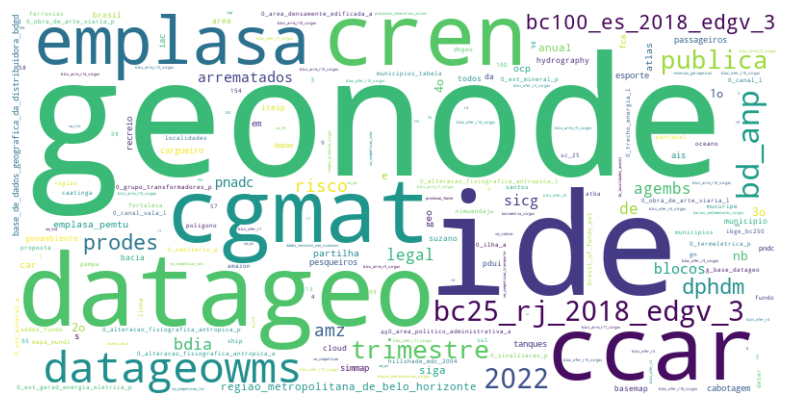

In [39]:
# Wordcloud for unclassified texts
from collections import Counter
from wordcloud import WordCloud
import unicodedata

# Tokenize, remove stop words, and normalize text for frequency analysis
words = []
stopwords = set(['and', 'the', 'on', 'in', 'of', 'are', 'not'])
for text in unclassified_texts:
    tokens = re.findall(r'\b\w+\b', text)
    words.extend([token for token in tokens if token not in stopwords])

# Generate a frequency distribution of words
word_freq = Counter(words)

# Generate a word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [41]:
# DataFrame enriched with the 'tema_fundamental' column
df_updated = pd.read_csv('../data/classified_data_v2_enriched.csv')

In [42]:
df_updated_filtered = df_updated[df_updated['tema_fundamental'] != 'Unclassified']

In [43]:
df_merged = pd.merge(df2_inde_scraped, df_updated_filtered[['titulo', 'tema_fundamental']], on='titulo', suffixes=('', '_updated'), how='left')

In [44]:
df_merged['tema_fundamental'] = df_merged['tema_fundamental_updated'].combine_first(df_merged['tema_fundamental'])

In [45]:
df_final = df_merged.drop(columns=['tema_fundamental_updated'])

In [76]:
df_final.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,sigla,tema_fundamental,escala,classification
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,,classified


In [47]:
len(df_final)

26717

#### Plots Fundamental Data Themes

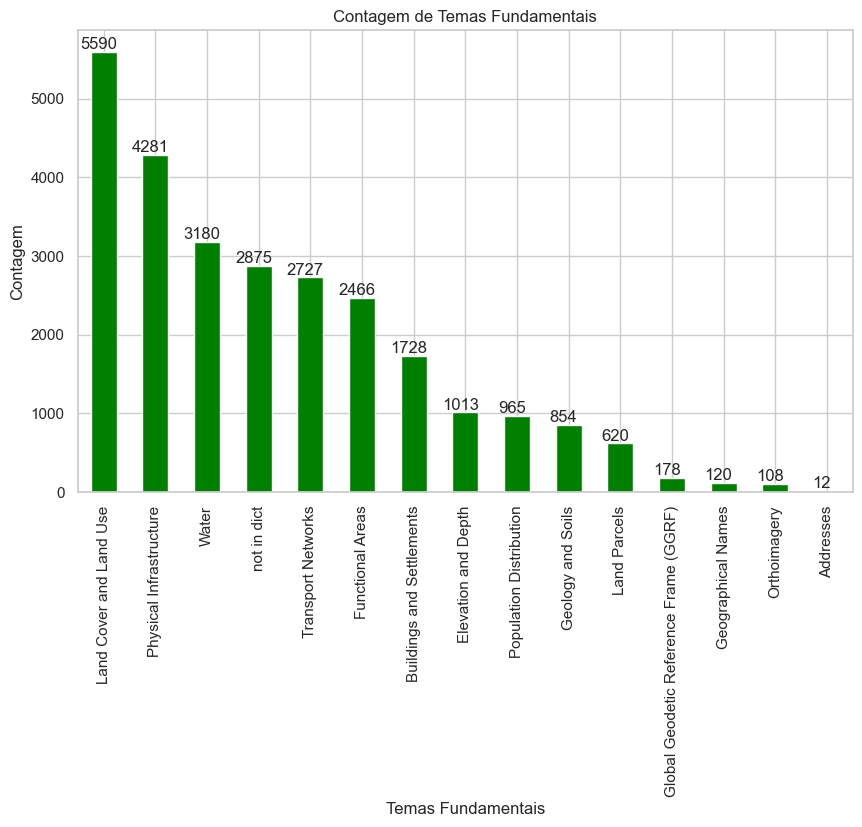

In [54]:
# Count of records by fundamental themes
tema_counts = df_final['tema_fundamental'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = tema_counts.plot(kind='bar', color='green')
plt.title('Contagem de Temas Fundamentais')
plt.xlabel('Temas Fundamentais')
plt.ylabel('Contagem')

# Add labels with values on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, f'{int(bar.get_height())}', ha='center', va='bottom')

plt.show()

In [90]:
# Filter out the unclassified themes
df_filtered = df_final[df_final['tema_fundamental'] != 'not in dict']

# Count the unique values of 'tema_fundamental'
tema_counts = df_filtered['tema_fundamental'].value_counts().reset_index()
tema_counts.columns = ['tema_fundamental', 'count']

# Calculate the percentage of each theme
total_count = tema_counts['count'].sum()
tema_counts['percent'] = (tema_counts['count'] / total_count) * 100

# Create the doughnut chart
fig = go.Figure(data=[go.Pie(
    labels=tema_counts['tema_fundamental'],
    values=tema_counts['count'],
    hole=.6,
    textinfo='label+percent',
    textposition='outside',
    marker=dict(colors=px.colors.qualitative.T10)
)])

# Update layout to remove the legend and adjust title
fig.update_layout(
    title_text='Distribution of Fundamental Geospatial Data Themes on INDE Geoportal',
    annotations=[dict(text='Temas', x=0.5, y=0.5, font_size=20, showarrow=False)],
    showlegend=False  # Hide the legend
)

# Update traces to reduce font size
fig.update_traces(textfont_size=12)

# Define the path and filename
path = '../results'  # Path to the results directory
filename = 'fig_doughnut_chart.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using kaleido
full_path = os.path.join(path, filename)
pio.write_image(fig, full_path, format='png', scale=3)  # scale=3 for approximately 300 dpi

# Display the chart
fig.show()

In [60]:
# Filter out the unclassified themes
df_filtered = df_final[df_final['tema_fundamental'] != 'not in dict']

# Count the unique values of 'tema_fundamental'
tema_counts = df_filtered['tema_fundamental'].value_counts().reset_index()
tema_counts.columns = ['tema_fundamental', 'count']

# Calculate the percentage of each theme
total_count = tema_counts['count'].sum()
tema_counts['percent'] = (tema_counts['count'] / total_count) * 100

# Create the label with name and percentage
tema_counts['label'] = tema_counts.apply(lambda row: f"{row['tema_fundamental']} {row['percent']:.1f}%", axis=1)

# Create the Tree Map
fig = px.treemap(
    tema_counts,
    path=['label'],
    values='count',
    title='Distribution of Fundamental Geospatial Data Themes on INDE Geoportal',
    color='count',
    color_continuous_scale='Viridis'
)

# Adjust the layout of the title
fig.update_layout(
    title={
        'text': "Distribution of Fundamental Geospatial Data Themes on INDE Geoportal",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Adjust the font size
fig.update_traces(textfont_size=14)

# Define the path and filename
path = '../results'  # Path to the results directory
filename = 'fig4_treemap.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using kaleido
full_path = os.path.join(path, filename)
pio.write_image(fig, full_path, format='png', scale=3)  # scale=3 for approximately 300 dpi

# Display the graph
fig.show()

### Classify the geospatial data layers according the Cartographic Scales

In [75]:
# Dictonary with scales and regex patterns to match
escalas = {
    '1k': r'1:1000',
    '2k': r'1:2000|2 mil',
    '10k': r'1:10000|10mil|10 mil',
    '25k': r'1:25.000|25mil|bc25|scn25',
    '50k': r'1:50.000|50mil',
    '70k': r'1:70.000|70mil',
    '100k': r'1:100.000|100mil',
    '250k': r'1:250.000|250mil|_250',
    '450k': r'1:450.000|450mil',
    '500k': r'1:500.000|500mil',
    '1M': r'1:1.000.000|milhão|milionésimo',
    '1100k': r'1:1.100.000',
    '1500k': r'1:1.500.000',
    '2M': r'1:2.000.000',
    '2500k': r'1:2.500.000',
    '4500k': r'1:4.500.000',
    '5M': r'1:5.000.000',
    '6M': r'1:6.000.000',
    '6400k': r'1:6.400.000',
    '7M': r'1:7.000.000',
    '8M': r'1:8.000.000',
    '8500k': r'1:8.500.000',
    '18M': r'1:18.000.000',
    '20M': r'1:20.000.000',
    '50M': r'1:50.000.000',
    '70M': r'1:70.000.000'
}

In [77]:
# Create a copy of the dataframe
df2_final = df_final.copy()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def associar_escala_por_colunas(row, colunas, escalas):
    for coluna in colunas:
        texto = preprocess_text(row[coluna])
        if texto: 
            for escala, pattern in escalas.items():
                if re.search(pattern, texto, re.IGNORECASE):
                    return escala
    return 'not in dict'  # Returna 'not in dict' with no match found


#  Columns to check for scaling in priority order
colunas = ['titulo', 'abstract', 'estilo_padrao', 'layer_name']

# Apply the function to each row
df2_final['escala'] = df2_final.apply(lambda row: associar_escala_por_colunas(row, colunas, escalas), axis=1)

In [78]:
df2_final.head()

,nome_instituicao,nivel_no,layer_name,titulo,abstract,estilo_padrao,SRC,sigla,tema_fundamental,escala,classification
0,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,0,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,not in dict,classified
1,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,1,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,not in dict,classified
2,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,2,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,not in dict,classified
3,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,3,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,not in dict,classified
4,ANA - Agência Nacional de Águas e Saneamento B...,Nacional,4,Usos Consuntivos da Água - Demanda hídrica por...,NaN,Usos Consuntivos da Água - Demanda hídrica por...,"['EPSG:4326', 'EPSG:4674']",ANA,Water,not in dict,classified


In [81]:
# Check the unique values in the 'escala' column
df2_final['escala'].unique()

array(['not in dict', '1M', '100k', '250k', '25k', '50k', '20M', '18M',
       '1500k', '1100k', '2500k', '4500k', '6M', '2M', '7M', '500k',
       '70k', '5M', '1k', '10k', '2k', '450k'], dtype=object)

In [102]:
# Save the final dataframe in CSV

# Define path and filename
path = '../data'  # Path to the results directory
filename = '20240506_classified_geoservices_inde_v2.csv'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save to results
full_path = os.path.join(path, filename)
save_df_to_csv(df2_final, full_path)

DataFrame saved successfully to '../data/20240506_classified_geoservicos_inde_v2.csv'


##### Plots of Fundamental Data Themes and Cartographic Scales

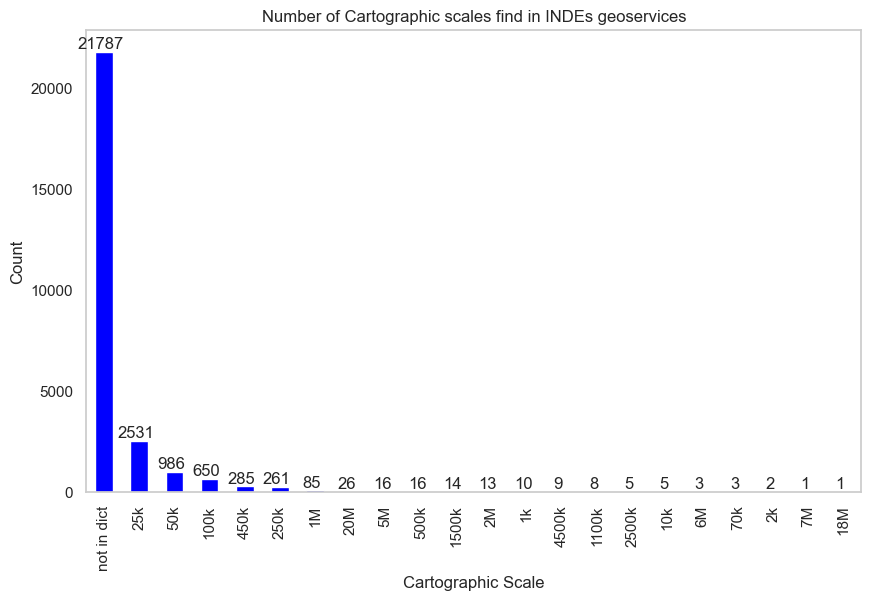

In [105]:
# Count of records by scale
tema_counts = df2_final['escala'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = tema_counts.plot(kind='bar', color='blue')
plt.title('Number of Cartographic scales find in INDEs geoservices')
plt.xlabel('Cartographic Scale')
plt.ylabel('Count')
plt.grid(False)

# Add labels with values
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, f'{int(bar.get_height())}', ha='center', va='bottom')

plt.show()

In [100]:
# Filter out the unclassified scales
df2_filtered = df2_final[df2_final['escala'] != 'not in dict']

# Count the unique values of scales
tema_counts = df2_filtered['escala'].value_counts().reset_index()
tema_counts.columns = ['escala', 'count']

# Calculate the percentage of scales
total_count = tema_counts['count'].sum()
tema_counts['percent'] = (tema_counts['count'] / total_count) * 100

# Create the label with name and percentage
tema_counts['label'] = tema_counts.apply(lambda row: f"{row['escala']} {row['percent']:.1f}%", axis=1)

# Create the Tree Map
fig = px.treemap(
    tema_counts,
    path=['label'],
    values='count',
    title='Distribution of Cartographic Scales on INDE Geoporta',
    color='count',
    color_continuous_scale='Viridis'
)

# Adjust the layout of the title
fig.update_layout(
    title={
        'text': "Distribution of Cartographic Scales on INDE Geoportal",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Adjust the font size
fig.update_traces(textfont_size=14)

# Define the path and filename
path = '../results'  # Path to the results directory
filename = 'fig_treemap_scales.png'  # Define the filename

# Ensure the results directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the figure with high resolution using kaleido
full_path = os.path.join(path, filename)
pio.write_image(fig, full_path, format='png', scale=3)  # scale=3 for approximately 300 dpi

# Display the graph
fig.show()

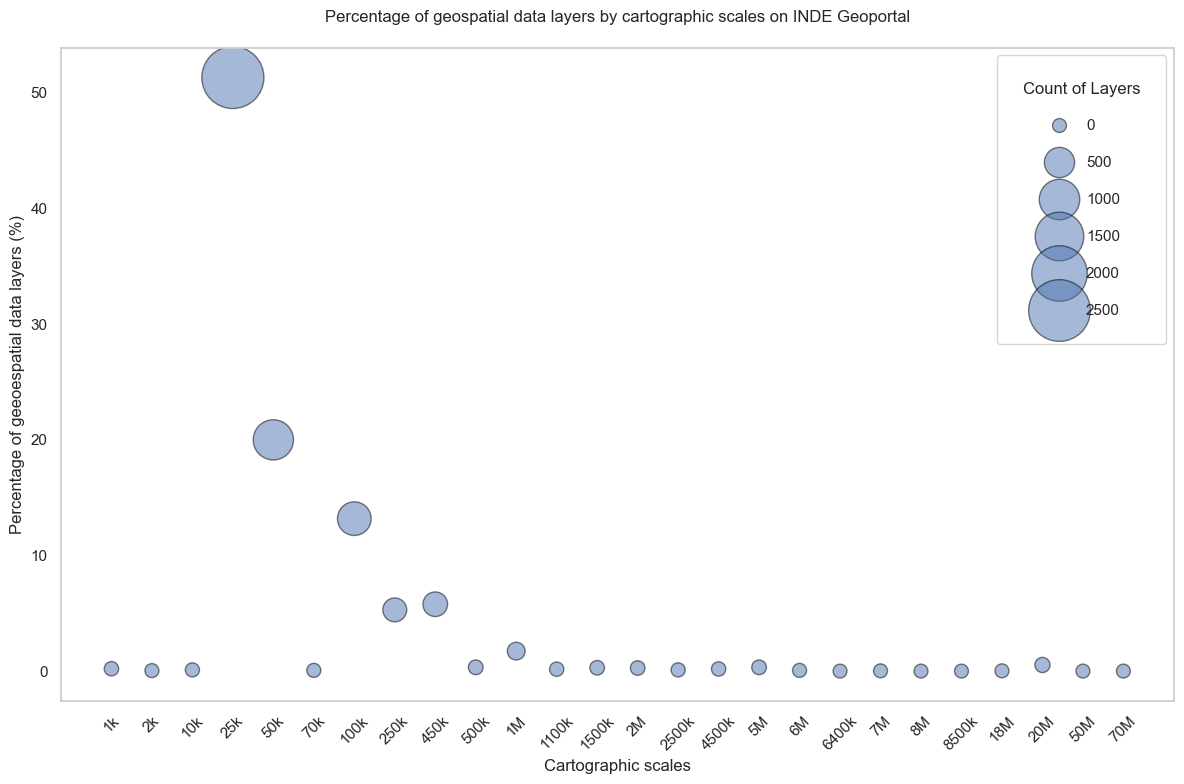

In [109]:
# The correct order for the scales
scale_order = ['1k', '2k', '10k', '25k', '50k', '70k', '100k', '250k', '450k', '500k', '1M', '1100k', 
               '1500k', '2M', '2500k', '4500k', '5M', '6M', '6400k', '7M', '8M', '8500k', '18M', '20M', 
               '50M', '70M']

# Filter the dataframe and ensure the 'escala' column is ordered correctly
df2_filtered['escala'] = pd.Categorical(df2_filtered['escala'], categories=scale_order, ordered=True)

# Count the scales
escala_counts = df2_filtered['escala'].value_counts().sort_index()

# Calculate the percentage of layers for each scale
layer_percentage = (escala_counts / escala_counts.sum()) * 100
df_plot = pd.DataFrame({'Scale': layer_percentage.index, 'Layer Percentage': layer_percentage, 'Count': escala_counts})

# Increase the figure size for the plot
plt.figure(figsize=(12, 8))

# Use seaborn to create a bubble plot
sns.scatterplot(data=df_plot, x='Scale', y='Layer Percentage', size='Count', sizes=(100, 2000), alpha=0.5, edgecolor='black', linewidth=1)

# Adjust legends and titles
plt.title('Percentage of geospatial data layers by cartographic scales on INDE Geoportal\n')
plt.xlabel('Cartographic scales')
plt.ylabel('Percentage of geeoespatial data layers (%)')
plt.grid(False)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Adjust the layout to avoid overlapping and fix the legend
plt.legend(title='Count of Layers', labelspacing=1.5, borderpad=1.7)
plt.tight_layout()

# Show the plot
plt.show()

SelectMultiple(description='Themes:', index=(1, 5), layout=Layout(height='270px', width='300px'), options=('Wa…

Button(description='Update Plot', style=ButtonStyle())

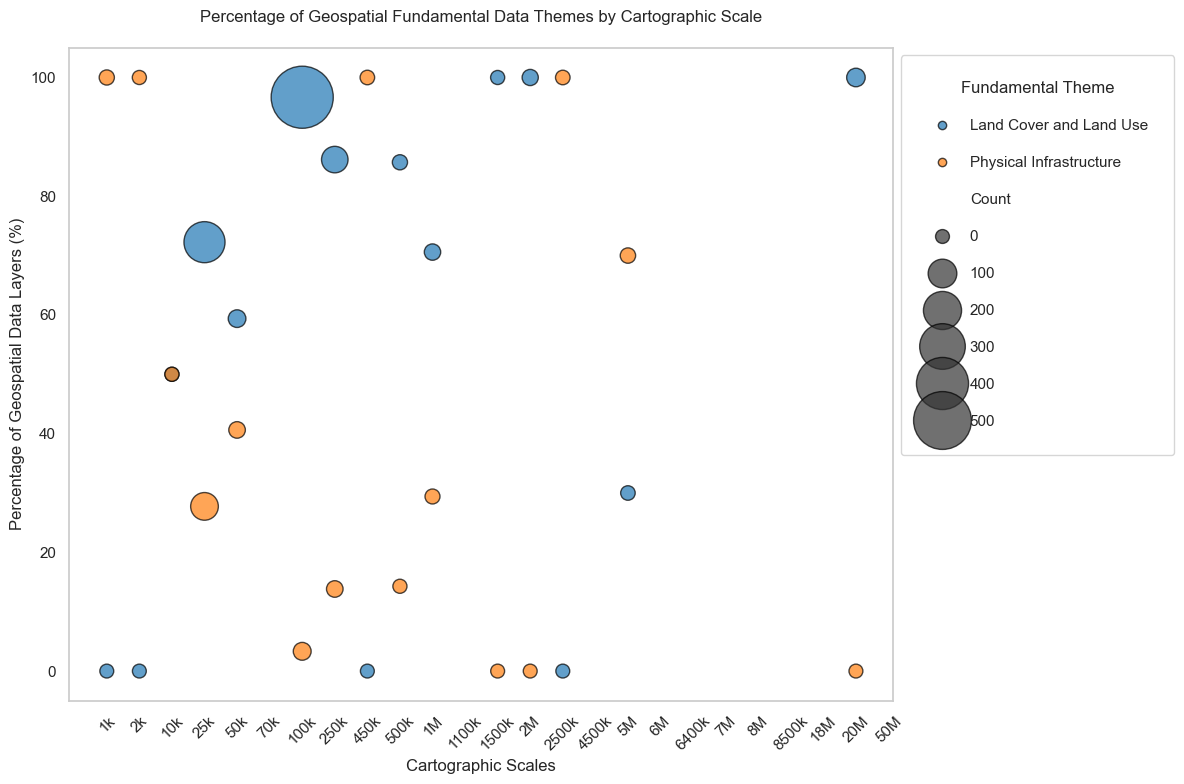

In [ ]:
# Define the correct order for the scales
scale_order = ['1k', '2k', '10k', '25k', '50k', '70k', '100k', '250k', '450k', '500k', '1M', '1100k', 
               '1500k', '2M', '2500k', '4500k', '5M', '6M', '6400k', '7M', '8M', '8500k', '18M', '20M', 
               '50M', '70M']

# Prepare and plot the data
def plot_filtered_data(selected_themes):
    clear_output(wait=True)
    display(selector, button)  # Redisplay widgets
    filtered_data = df2_final[(df2_final['escala'] != 'not in dict') & 
                              (df2_final['tema_fundamental'] != 'not in dict') & 
                              (df2_final['tema_fundamental'].isin(selected_themes))]
    
    # Ensure the 'escala' column is ordered correctly
    filtered_data['escala'] = pd.Categorical(filtered_data['escala'], categories=scale_order, ordered=True)
    filtered_data.sort_values('escala', inplace=True)

    grouped = filtered_data.groupby(['escala', 'tema_fundamental']).size().reset_index(name='Count')
    grouped['Total per Scale'] = grouped.groupby('escala')['Count'].transform('sum')
    grouped['Layer Percentage'] = (grouped['Count'] / grouped['Total per Scale']) * 100

    plt.figure(figsize=(12, 8))
    bubble = sns.scatterplot(data=grouped, x='escala', y='Layer Percentage', size='Count', 
                             sizes=(100, 2000), hue='tema_fundamental', alpha=0.7, 
                             edgecolor='black', linewidth=1, palette='tab10')  # Use a vibrant color palette
    plt.title('Percentage of Geospatial Fundamental Data Themes by Cartographic Scale\n')
    plt.xlabel('Cartographic Scales')
    plt.ylabel('Percentage of Geospatial Data Layers (%)')
    plt.xticks(rotation=45)
    plt.grid(False)
    
    # Adjust the legend
    handles, labels = bubble.get_legend_handles_labels()
    labels[0] = ''  # Remove 'tema_fundamental' from the legend
    plt.legend(handles=handles[1:], labels=labels[1:], title='Fundamental Theme', 
               labelspacing=1.5, borderpad=1.7, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

# Assuming df2_final is defined and loaded with data
themes = df2_final[df2_final['tema_fundamental'] != 'not in dict']['tema_fundamental'].unique()
selector = widgets.SelectMultiple(options=themes, value=[themes[0]], description='Themes:', 
                                  disabled=False, layout=widgets.Layout(width='300px', height='270px'))
button = widgets.Button(description="Update Plot")

def on_button_clicked(b):
    selected_themes = selector.value
    plot_filtered_data(selected_themes)

button.on_click(on_button_clicked)
display(selector, button)

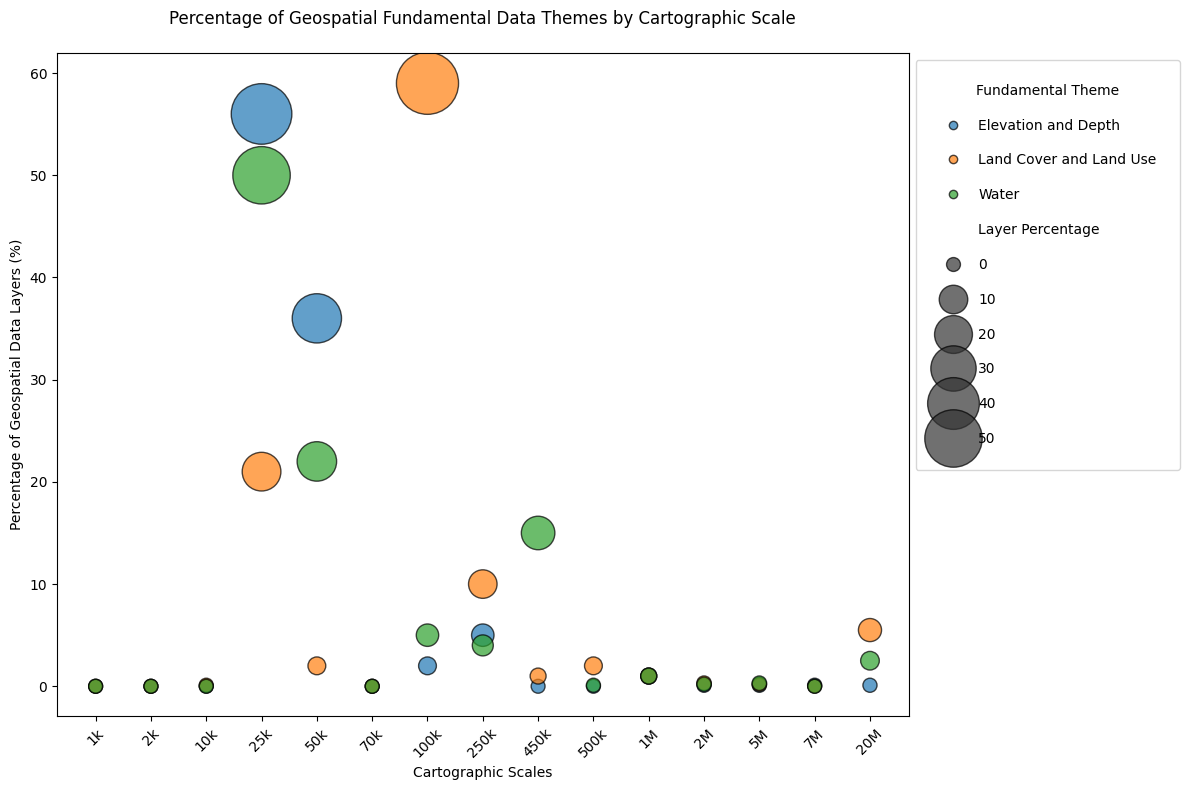

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Simulação dos dados (baseado nos exemplos fornecidos)
data = {
    'escala': ['1k', '2k', '10k', '25k', '50k', '70k', '100k', '250k', '450k', '500k',
               '1M', '2M', '5M', '7M', '20M'],
    'Elevation and Depth': [0, 0, 0, 56, 36, 0, 2, 5, 0, 0, 1, 0.1, 0.1, 0.1, 0.1],
    'Land Cover and Land Use': [0, 0, 0.1, 21, 2, 0, 59, 10, 1, 2, 1, 0.3, 0.2, 0, 5.5],
    'Water': [0, 0, 0, 50, 22, 0, 5, 4, 15, 0.1, 1, 0.2, 0.3, 0, 2.5]
}

# Criar DataFrame
df = pd.DataFrame(data)

# Transformar o DataFrame para o formato longo (long format) para usar com seaborn
df_long = df.melt(id_vars='escala', var_name='tema_fundamental', value_name='Layer Percentage')

# Ordem das escalas
scale_order = ['1k', '2k', '10k', '25k', '50k', '70k', '100k', '250k', '450k', '500k',
               '1M', '2M', '5M', '7M', '20M']

# Ajustar a ordem das escalas
df_long['escala'] = pd.Categorical(df_long['escala'], categories=scale_order, ordered=True)

# Criar o gráfico
plt.figure(figsize=(12, 8))
bubble = sns.scatterplot(
    data=df_long,
    x='escala',
    y='Layer Percentage',
    size='Layer Percentage',
    sizes=(100, 2000),
    hue='tema_fundamental',
    alpha=0.7,
    edgecolor='black',
    linewidth=1,
    palette='tab10'
)

# Títulos e rótulos
plt.title('Percentage of Geospatial Fundamental Data Themes by Cartographic Scale\n')
plt.xlabel('Cartographic Scales')
plt.ylabel('Percentage of Geospatial Data Layers (%)')
plt.xticks(rotation=45)
plt.grid(False)

# Ajustar a legenda
handles, labels = bubble.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],  # Remover a primeira entrada da legenda (tamanho dos círculos)
    labels=labels[1:], 
    title='Fundamental Theme', 
    labelspacing=1.5, 
    borderpad=1.7, 
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

# Layout ajustado
plt.tight_layout()

# Exibir o gráfico
plt.show()